## Lexicase Selection Numba加速

DEAP中Lexicase Selection的默认实现速度较慢。因此，我们可以尝试使用Numba来加速它。
Numba的原理是将Python代码编译为LLVM中间代码，然后再编译为机器码。从而显著提高Python代码的运行速度。

In [1]:
import numpy as np
import math
import operator

from deap import base, creator, tools, gp
import time


# 符号回归
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100) 
    
    return tuple((func(x) - x**2)**2)


# 创建个体和适应度函数，适应度数组大小与数据量相同
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * 100)  # 假设我们有100个数据点
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### 遗传算子
在使用Numba进行对Lexicase加速时，只需要重写Lexicase函数，加上@njit(cache=True)这个注解就可以了。
需要注意一些特殊的函数可能不受Numba支持，但所有基本的Python运算符都是支持的。

In [2]:
from numba import njit
import numpy as np


@njit(cache=True)
def selAutomaticEpsilonLexicaseNumba(case_values, fit_weights, k):
    selected_individuals = []
    avg_cases = 0

    for i in range(k):
        candidates = list(range(len(case_values)))
        cases = np.arange(len(case_values[0]))
        np.random.shuffle(cases)

        while len(cases) > 0 and len(candidates) > 1:
            errors_for_this_case = np.array(
                [case_values[x][cases[0]] for x in candidates]
            )
            median_val = np.median(errors_for_this_case)
            median_absolute_deviation = np.median(
                np.array([abs(x - median_val) for x in errors_for_this_case])
            )
            if fit_weights > 0:
                best_val_for_case = np.max(errors_for_this_case)
                min_val_to_survive = best_val_for_case - median_absolute_deviation
                candidates = list(
                    [
                        x
                        for x in candidates
                        if case_values[x][cases[0]] >= min_val_to_survive
                    ]
                )
            else:
                best_val_for_case = np.min(errors_for_this_case)
                max_val_to_survive = best_val_for_case + median_absolute_deviation
                candidates = list(
                    [
                        x
                        for x in candidates
                        if case_values[x][cases[0]] <= max_val_to_survive
                    ]
                )
            cases = np.delete(cases, 0)
        avg_cases = (avg_cases * i + (len(case_values[0]) - len(cases))) / (i + 1)
        selected_individuals.append(np.random.choice(np.array(candidates)))
    return selected_individuals, avg_cases

def selAutomaticEpsilonLexicaseFast(individuals, k):
    fit_weights = individuals[0].fitness.weights[0]
    case_values = np.array([ind.fitness.values for ind in individuals])
    index, avg_cases = selAutomaticEpsilonLexicaseNumba(case_values, fit_weights, k)
    selected_individuals = [individuals[i] for i in index]
    return selected_individuals

详细解释一下这段代码中使用 Numba 加速的原理。这涉及到几个关键概念:

1. JIT(即时编译)原理:
@njit 装饰器的核心作用是启用即时编译。当代码第一次运行时,Numba 会将 Python 代码编译成机器码。这与普通 Python 代码的解释执行方式有本质区别。机器码可以直接被 CPU 执行,不需要 Python 解释器的介入,从而获得接近原生 C/C++ 的性能。

2. 静态类型特化:
Numba 在编译过程中会对代码进行静态类型分析。在这段代码中:
```python
case_values = np.array([ind.fitness.values for ind in individuals])
```
当数据被转换为 NumPy 数组后,Numba 可以确定具体的数据类型(如 float64),从而生成优化的机器码。这避免了 Python 的动态类型检查开销。

3. 循环优化:
代码中包含多层嵌套循环:
```python
for i in range(k):
    while len(cases) > 0 and len(candidates) > 1:
        # 内层循环逻辑
```
Numba 会将这些 Python 循环转换为底层的循环指令,并应用循环展开、向量化等优化技术。这大大减少了循环迭代的开销。

4. NumPy 操作优化:
代码中大量使用了 NumPy 操作:
```python
np.median(errors_for_this_case)
np.array([abs(x - median_val) for x in errors_for_this_case])
```
Numba 可以将这些高级操作直接映射到底层的 SIMD(单指令多数据)指令,实现并行计算。

5. 内存访问优化:
Numba 会优化数组访问模式,尽可能利用 CPU 缓存,减少内存访问延迟。例如,在处理 case_values 数组时,会尽量保持连续的内存访问。

6. 缓存机制:
注意到装饰器使用了 cache=True 参数:
```python
@njit(cache=True)
```
这启用了编译结果缓存。第一次运行后,编译好的机器码会被保存,后续运行可以直接使用,避免重复编译。

实际加速效果:
- 对于大规模数据(较大的 case_values 数组),加速效果可能达到几十倍甚至上百倍。
- 但对于小规模数据,编译开销可能抵消性能提升。
- 加速效果与代码的数值计算密集程度、循环结构、数组操作等特征有关。

需要注意的限制:
1. Numba 只能优化特定类型的操作,主要是数值计算和数组操作。
2. 不支持复杂的 Python 对象操作和大多数 Python 标准库函数。
3. 函数内部的代码需要符合 Numba 的类型推断规则。

这段代码的优化效果很好,因为它主要包含:
- 密集的数值计算
- 大量的数组操作
- 嵌套循环结构

这些都是 Numba 擅长优化的场景。

在定义好了新的Lexicase选择算子之后，在注册选择算子的时候，将新的选择算子注册进去就可以了。

In [3]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", selAutomaticEpsilonLexicaseFast)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


### 演化流程
演化流程与传统符号回归相同。

In [4]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用Numba加速
numba_lexicase_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end = time.time()
    print(str(hof[0]))
    numba_lexicase_time.append(end - start)


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min	nevals	std    	avg 	gen	max	min	nevals	std    
0  	100   	2138.36	0  	44100	0  	100   	3358.48	3.92	0  	7  	2  	100   	1.61666
1  	96    	358.01 	1  	40000	0  	96    	2210.93	3.11	1  	7  	2  	96    	0.66174
2  	95    	1831.59	2  	1e+06	0  	95    	29443.9	3.39	2  	9  	2  	95    	1.19912
3  	91    	355.239	3  	44100	0  	91    	2509.99	3.24	3  	7  	3  	91    	0.763151
4  	94    	2058.49	4  	1.21e+06	0  	94    	30622.6	3.44	4  	8  	2  	94    	0.993177
5  	94    	356.9  	5  	40000   	0  	94    	1852.28	3.33	5  	7  	3  	94    	0.837317
6  	92    	750.645	6  	160000  	0  	92    	6084.76	3.41	6  	8  	3  	92    	1.03049 
7  	95    	3261.56	7  	1.21e+06	0  	95    	42248.4	3.3 	7  	9  	3  	95    	1.06301 
8  	88    	1893.68	8  	1e+06   	0  	88    	29471.

为了展示Numba加速的效果，我们将使用纯Python实现的Lexicase Selection进行对比。

In [5]:
# 使用纯Python实现的Lexicase Selection
toolbox.register("select", tools.selAutomaticEpsilonLexicase)
python_lexicase_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end = time.time()
    print(str(hof[0]))
    python_lexicase_time.append(end - start)

   	      	                       fitness                       	                      size                     
   	      	-----------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max     	min	nevals	std  	avg 	gen	max	min	nevals	std    
0  	100   	3850.03	0  	1.21e+06	0  	100   	30603	4.07	0  	7  	2  	100   	1.66886
1  	91    	62.7805	1  	12100   	0  	91    	604.967	3.08	1  	7  	3  	91    	0.503587
2  	95    	3325.71	2  	1.21e+06	0  	95    	42954.9	3.21	2  	9  	2  	95    	0.851998
3  	86    	3345.49	3  	1.21e+06	0  	86    	43021.4	3.27	3  	9  	2  	86    	1.11225 
4  	89    	2540.95	4  	1.21e+06	0  	89    	30820.6	3.57	4  	9  	3  	89    	1.35096 
5  	90    	1045.8 	5  	102400  	0  	90    	5973.33	3.46	5  	12 	2  	90    	1.51275 
6  	90    	188.001	6  	12100   	0  	90    	1032.14	3.29	6  	9  	3  	90    	1.02269 
7  	96    	125029 	7  	1.0201e+08	0  	96    	2.67838e+06	3.31	7  	9  	2  	96    	1.14625 
8  	92    	418.32 

下面是Numba加速和纯Python实现的Lexicase Selection的运行时间对比。从结果可以看出，Numba加速后的Lexicase Selection的运行速度远优于纯Python实现的Lexicase Selection。

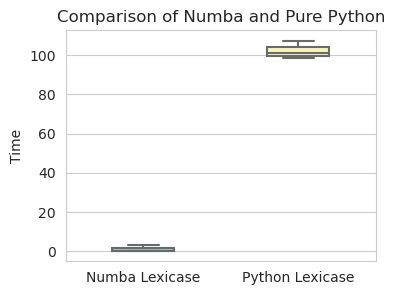

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame(
    {'Category': ['Numba Lexicase'] * len(numba_lexicase_time) + ['Python Lexicase'] * len(python_lexicase_time),
     'Time': np.concatenate([numba_lexicase_time, python_lexicase_time])})

plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time', palette="Set3", width=0.4)
plt.title('Comparison of Numba and Pure Python')
plt.xlabel('')
plt.ylabel('Time')
plt.show()